## SDSS spectral analyzer to infer stellar distances
#### Written by Caden Gobat for ASTR 3141 at the George Washington University

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, pickle, scipy, astropy.coordinates as coord, astropy.units as u
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from PyAstronomy import pyasl
mpl.rcParams['font.family'] = 'serif'

c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
full_catalog = pd.read_csv('SDSS12query_TOP99999.csv') # culled to only include *stars* with a quality rating of 3 (max)
full_catalog.rename(columns={'RA_ICRS': 'RA','DE_ICRS': 'DE','Sp-ID': 'SpID'}, inplace=True)
ugriz = {'umag':355.1,'gmag':468.6,'rmag':616.5,'imag':748.1,'zmag':893.1}
lumClasses = ['Ia', 'Ia+', 'Iab', 'Ib', 'II', 'III', 'IV', 'V']
specClasses = list("OBAFGKM")
# https://en.wikipedia.org/wiki/Photometric_system for info on ugriz band letters

In [3]:
objList = full_catalog.copy().drop(['ObsDate','spType','pmRA','pmDE','chi2'],axis=1).dropna(subset=['subCl']) # unnecessary data
objList = objList[[any(Cl[0]==x for x in specClasses) & any(x in Cl for x in lumClasses) for Cl in objList.subCl]]
for i in objList.index: # the above drops everything that is not a star with a standard spectral class. This loop parses the class
    Cl = objList.loc[i,'subCl'].strip().split()[0] # discard everything after a space, if one exists
    Cl = Cl.split('/')[-1] # take the second part after a /, if one exists
    objList.loc[i,'subCl'] = Cl # reassign the clean subCl
with open('goodfits.pkl','rb') as fitfile: # the model was run and dumped to a pickle file for easy access
    goodfits = pickle.load(fitfile) # includes the indices of all stars for which R^2 >= 0.96
with open('goodtemps.pkl','rb') as tempfile:
    goodtemps = pickle.load(tempfile) # includes the indices of all stars for which the difference between spectrally derived temp and class-derived temp <= 1000 K
all_good = list(set(goodtemps) & set(goodfits)) # get the common items between the two lists
all_good.sort() # put the list of indices back in order

In [4]:
def planck(wavelength,T,amp): #in nm
    h = 6.626e-34 # Planck's constant, J*s
    c = 299792458 # speed of light, m/s
    k = 1.38064852e-23 # Boltzmann constant, J/K
    B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law
    return B # W/m^2/nm

def wien(T):
    b = 2.897771955e-3 # Wien's displacement constant, in m*K
    λ_max = (b/T)*1e9 # Wien's Law, with λ converted from nm
    return λ_max # in K


def ugriz_to_UBVRI(mags): # Jordi et al. (2006)
    u,g,r,i,z = [mag for mag in mags]
    
    UB = 0.79*(u-g) - 0.93 #U-B = (0.79±0.02)*(u-g) - (0.93±0.02)
    B = 0.313*(g-r) + 0.219 + g #B-g = (0.313±0.003)*(g-r) + (0.219±0.002)
    if  g-i <= 2.1:
        VI = 0.675*(g-i)  + 0.364 #V-I = (0.675±0.002)*(g-i) + (0.364±0.002) if g-i <= 2.1
    elif g-i > 2.1:
        VI = 1.11*(g-i) - 0.52 #V-I = (1.11±0.02)*(g-i) - (0.52±0.05) if  g-i >  2.1
    R = -0.153*(r-i) - 0.117 + r #R-r = (-0.153±0.003)*(r-i) - (0.117±0.003)
    I = -0.386*(i-z) - 0.397 + i #I-i = (-0.386±0.004)*(i-z) - (0.397±0.001)
    U = UB + B
    V = VI + I

    return U,B,V,R,I


def ugriz_to_flux(ugrizmags,errors=np.zeros(5)): # complete function that converts a set of ugriz magnitudes to flux in MKS units
    UBVRI = dict(zip(["U","B","V","R","I"],ugriz_to_UBVRI(ugrizmags))) 

    maxmag, minmag = ugriz_to_UBVRI(ugrizmags-errors), ugriz_to_UBVRI(ugrizmags+errors)
    fluxes, wavelengths, maxflux, minflux = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])
    
    for i in range(len(UBVRI)):
        fluxes[i], wavelengths[i] = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], UBVRI[list(UBVRI)[i]], "lam") # in CGS & Å
        maxflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], maxmag[i], "lam")
        minflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], minmag[i], "lam")
    
    wavelengths *= 0.1 # Ang to nm
    fluxes *= 1e-4*0.1/1e-7 # erg/s/cm^2/Ang to W/m^2/nm
    minflux *= 1e-4*0.1/1e-7
    maxflux *= 1e-4*0.1/1e-7
    
    negerrors, poserrors = fluxes-minflux, maxflux-fluxes
    
    return pd.DataFrame(zip(UBVRI.keys(),wavelengths,fluxes,negerrors,poserrors),columns=('band','wavelength','flux','e_neg','e_pos'))


def calculate(obj): # calculates the important values given an object's index in the catalog
    magnitudes = np.array(objList.loc[obj,ugriz.keys()])
    errors = np.array(objList.loc[obj,['e_'+band for band in ugriz.keys()]])

    spectrum = ugriz_to_flux(magnitudes,errors)
    
    fit_params, cov_mat = curve_fit(planck, spectrum['wavelength'], spectrum['flux'], p0=[7000,1e-30])
    uncertainties = np.sqrt(np.diag(cov_mat))
    T = fit_params[0]
    amp = fit_params[1]
    λ_max = wien(T) # in nm, from temperature in K
    baseλ = np.arange(250,1050)
    
    spectrum['fit'] = planck(spectrum['wavelength'],*fit_params)
    conf_region = (planck(baseλ,T-uncertainties[0],amp-uncertainties[1]), planck(baseλ,T+uncertainties[0],amp+uncertainties[1]))
    fluxerrors = [spectrum['e_neg'],spectrum['e_pos']]


    fit_residual = spectrum['flux'] - spectrum['fit']
    fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['flux'])
    fit_Chi_sq = np.sum((spectrum['flux'] - spectrum['fit'])**2/spectrum['fit'])
    
    lumClass  = objList.loc[obj,'subCl'][2:].strip()
    specClass = objList.loc[obj,'subCl'][:2]
    Cl = specClass+lumClass

    loglum, logTeff = sdj.lumAndTeff(specClass, lumClass)
    lum, Teff = (10**loglum)*3.828e26, 10**logTeff
    intFlux = np.sum(planck(np.arange(1,4000),*fit_params))
    dist = np.sqrt(lum/(4*np.pi*intFlux))
    
    return dist, T, Teff


sdj = pyasl.SpecTypeDeJager()

### Create and fit the blackbody spectrum

In [5]:
# Select object and obtain magnitudes
objIndex = np.random.choice(all_good) # pick a star to analyze
obj = 3792 #int(objIndex) #3792, 7935, 24141, 96757
SpID = objList.loc[obj,'SpID'] # parse plate, mjd, and fiber info
magnitudes = np.array(objList.loc[obj,ugriz.keys()]) # read the values of the magnitudes in each of the five ugriz channels
errors = np.array(objList.loc[obj,['e_'+band for band in ugriz.keys()]]) # read the corresponding rms errors

spectrum = ugriz_to_flux(magnitudes,errors)
print(f"#{obj} loaded successfully")

# Fit data

fit_params, cov_mat = curve_fit(planck, spectrum['wavelength'], spectrum['flux'], p0=[7000,1e-30]) # (function,x,data,starting guesses)
uncertainties = np.sqrt(np.diag(cov_mat))
T = fit_params[0]
amp = fit_params[1]
λ_max = wien(T) # in nm, from temperature in K
baseλ = np.arange(250,1050)

spectrum['fit'] = planck(spectrum['wavelength'],*fit_params)
conf_region = (planck(baseλ,T-uncertainties[0],amp-uncertainties[1]), planck(baseλ,T+uncertainties[0],amp+uncertainties[1]))
fluxerrors = [spectrum['e_neg'],spectrum['e_pos']]


fit_residual = spectrum['flux'] - spectrum['fit']
sigma = np.std(fit_residual)
fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['flux'])
fit_Chi_sq = np.sum((spectrum['flux'] - spectrum['fit'])**2/spectrum['fit'])

caption = "Obj temperature: %.2f \u00b1 %.3f K \nScaling factor: %.3e \u00b1 %.3e \nSpectrum peak λ: %.2f \u00b1 %.3f nm \nFit R-squared: %f" %(fit_params[0],uncertainties[0],fit_params[1],uncertainties[1],λ_max,wien(T)-wien(T+uncertainties[0]),fit_Rsquared)
print(caption)


# Calculate temp and luminosity based on stellar class

lumClass  = objList.loc[obj,'subCl'][2:].strip()
specClass = objList.loc[obj,'subCl'][:2]
Cl = specClass+lumClass

loglum, logTeff = sdj.lumAndTeff(specClass, lumClass)
lum, Teff = (10**loglum)*3.828e26, 10**logTeff # convert to normal physical units
print("Stellar class: %s \nLuminosity: %.4e W \nTemperature: %.4f K" %(Cl,lum,Teff))
intFlux = np.sum(planck(np.arange(1,5000),*fit_params))
dist = np.sqrt(lum/(4*np.pi*intFlux))
print("Distance: %.4e m (%.1f ly)" %(dist,dist/9460730000000000))

#3792 loaded successfully
Obj temperature: 7685.54 ± 236.458 K 
Scaling factor: 1.338e-29 ± 1.779e-30 
Spectrum peak λ: 377.04 ± 11.254 nm 
Fit R-squared: 0.981968
Stellar class: F0III 
Luminosity: 1.7384e+28 W 
Temperature: 7121.5250 K
Distance: 4.0562e+19 m (4287.4 ly)


c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


### Plot the data and model

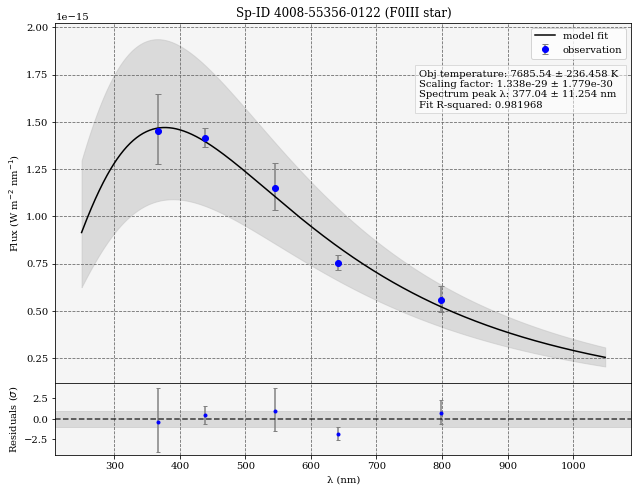

In [6]:
#Create main spectrum plot

fig, ax = plt.subplots(figsize=(8, 5))
fig.set_facecolor('white')

#Plot Data & model
main_frame = fig.add_axes((0,.2,1,1)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],spectrum['flux'],fmt='ob',yerr=fluxerrors,ecolor='grey',label='observation',capsize=3)
plt.plot(baseλ, planck(baseλ,*fit_params), color='black',label='model fit')
plt.fill_between(baseλ, *conf_region, color='silver', alpha=.5)
plt.ylabel("Flux (W m$^{-2}$ nm$^{-1}$)")
xlimits = plt.gca().get_xlim()
plt.title(f"Sp-ID {SpID} ({Cl} star)")
plt.legend()
plt.grid(color='dimgrey', linestyle='--')

#Residual plot
res_frame = fig.add_axes((0,0,1,.2)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],fit_residual/sigma,fmt='.b',yerr=fluxerrors/sigma,ecolor='grey',capsize=2)
plt.axhline(linestyle='--',color='black',alpha=.75) # 0 baseline
plt.fill_between(xlimits, [-1,-1], [1,1], color='silver', alpha=.5)
plt.ylabel('Residuals ($\sigma$)')
plt.gca().set_xlim(xlimits)
plt.gca().set_ylim(-1*max(np.abs(plt.gca().get_ylim())),max(np.abs(plt.gca().get_ylim())))
plt.gca().xaxis.grid(color='dimgrey', linestyle='--')
plt.xlabel("λ (nm)")
fig.text(.632,.965,caption,bbox=dict(facecolor='w',edgecolor='silver',alpha=0.5))
plt.savefig(f'example_{obj}.png',bbox_inches='tight')

### Visualizations of spectral class temperature/luminosity relations

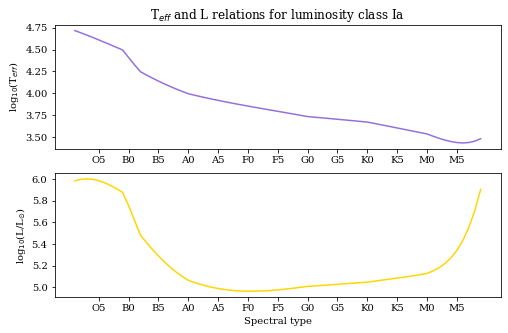

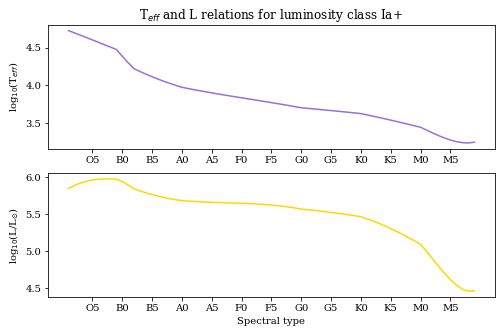

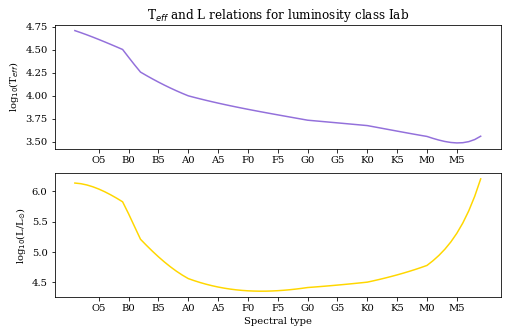

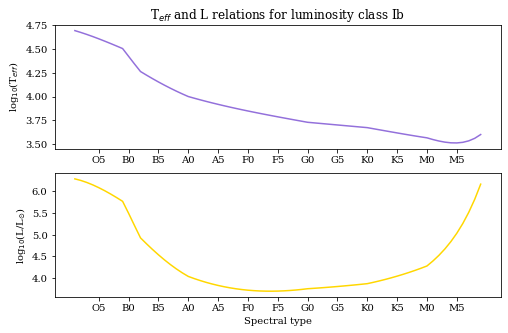

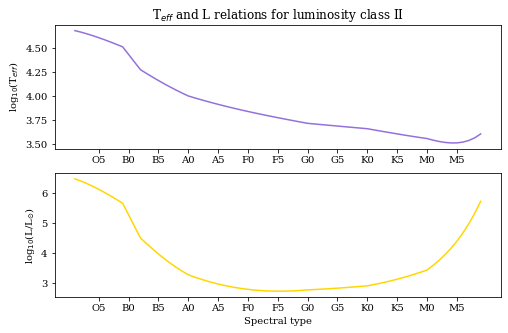

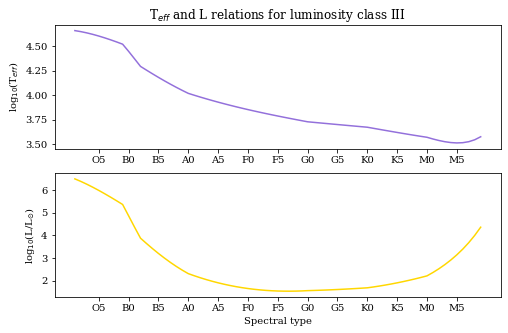

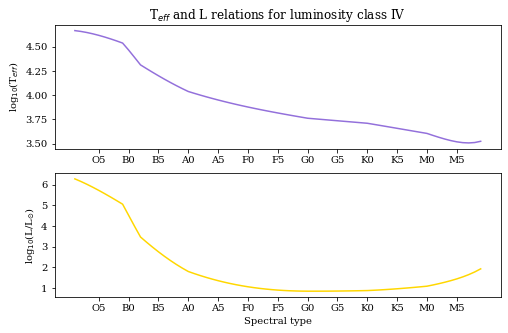

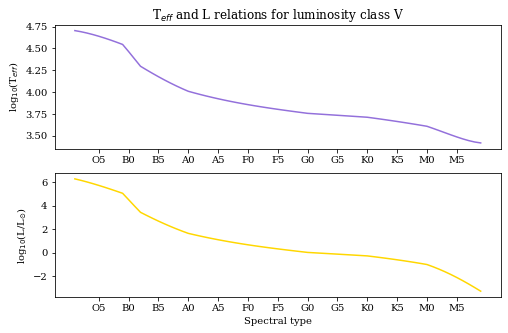

In [7]:
for lumClass in lumClasses:
    temps = []
    lums = []

    tickpositions = []
    ticklabels = []

    for t in specClasses:
        for n in range(10):
            if (t == "O") and (n == 0):
                # "O0" type doesn't exist
                continue

            # Save the spectral type
            specClass = t + str(n)

            # Get log10 of luminosity and effective temperature
            logL, logT = sdj.lumAndTeff(specClass, lumClass)
            # and save to lists
            lums.append(logL)
            temps.append(logT)

            if (n == 0) or (n == 5):
                tickpositions.append(len(lums)-1)
                ticklabels.append(specClass)
    

    fig, _ = plt.subplots(figsize=(8,5))
    ax1 = plt.subplot(2,1,1)
    # Plot log10(effective temperature)
    plt.plot(temps, color='mediumpurple')
    plt.title("T$_{eff}$ and L relations for luminosity class %s" %lumClass)
    plt.ylabel("log$_{10}$(T$_{eff}$)")
    plt.setp(ax1, xticks=tickpositions,xticklabels=ticklabels)
    ax2 = plt.subplot(2,1,2)
    # Plot log10(luminosity)
    plt.plot(lums, color='gold')
    plt.ylabel("log$_{10}$(L/L$_{\odot}$)")
    plt.setp(ax2, xticks=tickpositions,xticklabels=ticklabels)
    plt.xlabel("Spectral type")
    plt.savefig(f'TandL_{lumClass}.png')

### Calculate distances for a multitude of stars

Invoke the fitting algorithm in a loop to get distances for all stars in the list

In [30]:
t0 = time.time()

distances = pd.Series([])
spectemps = pd.Series([])
classtemps = pd.Series([])

for i in all_good:
    distances[i], spectemps[i], classtemps[i] = calculate(i)
    frac_complete = len(distances)/len(all_good)
    full_progbar = 20
    filled_progbar = round(frac_complete*full_progbar)
    print("", end="\rObject #{} of {} completed ({:>4.2%}). Progress: [".format(i,max(all_good),frac_complete)+'#'*filled_progbar + '-'*(full_progbar-filled_progbar)+"]")

t1 = time.time()

total = t1-t0
print("\nTime to complete:",total)

c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Object #99978 of 99978 completed (100.00%). Progress: [####################]
 168.84073758125305


### Chart of stars in this part of the catalog

The dominant color in this map is bright pink, which corresponds to main sequence stars (class V). This makes sense, as stars on the main sequence are the most common.

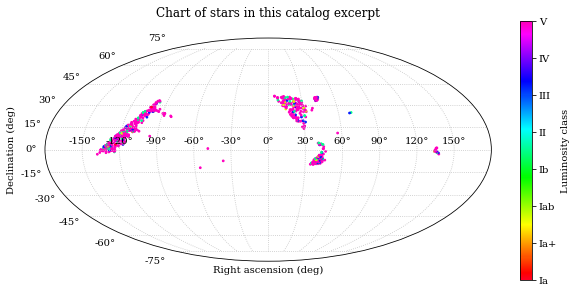

In [31]:
ra = coord.Angle(objList.loc[all_good,'RA'],unit=u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(objList.loc[all_good,'DE'],unit=u.degree)
fig, ax = plt.subplots(figsize=(8,6),subplot_kw={'projection': "mollweide"})
ax.grid(color='silver', linestyle=':')
ax.scatter(ra.radian, dec.radian,c=[lumClasses.index(lumCl) for lumCl in [objList.loc[i,'subCl'][2:].strip() for i in distances.index]],cmap='gist_rainbow',s=3)

plt.title("Chart of stars in this catalog excerpt\n")
plt.xlabel("Right ascension (deg)")
plt.ylabel("Declination (deg)")

cmap = plt.cm.gist_rainbow
norm = mpl.colors.Normalize(vmin=1, vmax=len(lumClasses))
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
cb.ax.set_yticklabels(lumClasses)
cb.set_label('Luminosity class')

plt.savefig('class_skymap.png',bbox_inches='tight')
plt.show()

### Visualization of discrepancies between temperature calculation methods

One is calculated using the converted spectrum and Wien's law. The other is from the stars spectral class. All differences over 1000K have been discarded.

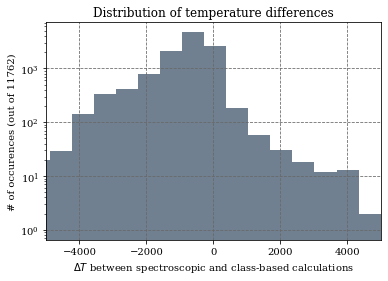

In [28]:
tempdiffs = all_spectemps - all_classtemps
plt.hist(tempdiffs,249,color='slategrey')
plt.xlabel("$\Delta T$ between spectroscopic and class-based calculations")
plt.ylabel("# of occurences (out of "+str(len(tempdiffs))+")")
plt.title("Distribution of temperature differences")
plt.savefig('temp_hist.png',bbox_inches='tight')
plt.xlim((-5000,5000))
plt.yscale('log')
plt.grid(color='dimgrey', linestyle='--')
plt.savefig('tempdiffs.png',bbox_inches='tight')
plt.show()

In [36]:
scipy.stats.describe(distances)

DescribeResult(nobs=630, minmax=(1.1776283324464218e+17, 4.9407691019353915e+20), mean=1.4606295178695772e+19, variance=1.3501541657869506e+39, skewness=6.219583103215481, kurtosis=55.57613015308622)